In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX


DB_PATH = '/Users/beans/Desktop/TeamHousing/data/processed/nyc_demolitions.db'
HOUSING_PATH = '/Users/beans/Desktop/TeamHousing/data/HousingDB_post2010.csv'
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

queryowner_demo = """
SELECT *
FROM fact_demolitions f   
"""

fact_owner_demo = pd.read_sql_query(queryowner_demo, conn)

queryshelter = """
SELECT *
FROM fact_shelters
"""
fact_shelter = pd.read_sql_query(queryshelter, conn)

display(fact_owner_demo.sort_values(by=['bin'],ascending=False).head())
display(fact_shelter.sort_values(by=['report_date'],ascending=False).head())

# setting job_typeid to strings to represent what the job done is
mapdemo = {1:'construction',2:'demolition'}
fact_owner_demo['job_typeid'] = fact_owner_demo['job_typeid'].map(mapdemo)

# setting ownership_id 1 to private and 2/3 to affordable (government & nonprofit)
mapowner = {1:'private',2:'affordable',3:'affordable'}
fact_owner_demo['ownership_id'] = fact_owner_demo['ownership_id'].map(mapowner)


,month_date,bin,job_typeid,ownership_id,borough,date_filed,date_completed,time_of_completion
13032,2023-03-01 00:00:00,5869568,2,1,Staten Island,2022-11-18 00:00:00,2023-03-13 00:00:00,115
12397,2018-08-01 00:00:00,5867189,2,1,Staten Island,2018-06-21 00:00:00,2018-08-03 00:00:00,43
12395,2018-09-01 00:00:00,5867187,2,1,Staten Island,2018-06-21 00:00:00,2018-09-24 00:00:00,95
12394,2018-11-01 00:00:00,5867186,2,1,Staten Island,2018-06-21 00:00:00,2018-11-26 00:00:00,158
12393,2018-11-01 00:00:00,5867185,2,1,Staten Island,2018-06-21 00:00:00,2018-11-26 00:00:00,158


,report_date,shelter_count
106,2024-12-01 00:00:00,67298
107,2024-11-01 00:00:00,66981
108,2024-10-01 00:00:00,67218
109,2024-09-01 00:00:00,68336
110,2024-08-01 00:00:00,68549


In [34]:
shelter = fact_shelter.copy()

shelter['report_date'] = pd.to_datetime(shelter['report_date'])

#shelter has some duplicate dates
shelter['report_date'].value_counts()
shelter = shelter.drop_duplicates(subset=['report_date'])

# renaming to be able to merge
shelter= shelter.rename(mapper={'report_date':'month_date'},axis=1)

shelter = shelter.sort_values(by='month_date',ascending=True)


s = shelter.set_index(shelter['month_date'])['shelter_count'].asfreq('MS')


In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(s)
print(f"p value is: {adf_result[1]:.10f}")

# p value is less than 0.05, indicating stationarity

p value is: 0.0029566160


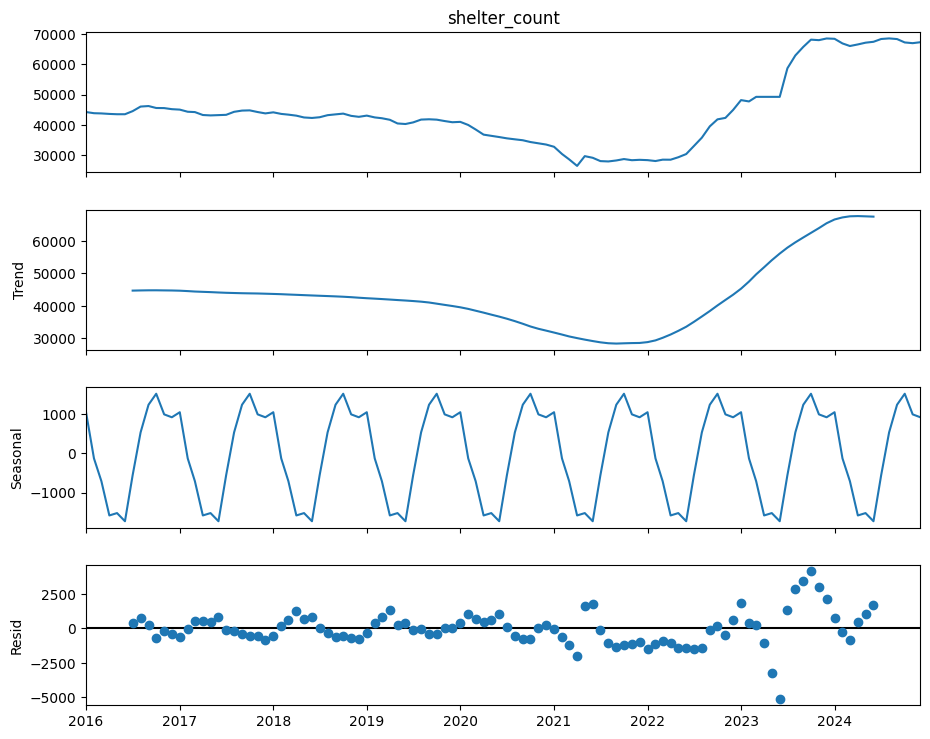

In [90]:
from statsmodels.tsa.seasonal import seasonal_decompose
# decompose the time series (assuming a 12-month cycle)
decomp = seasonal_decompose(s, model='additive', period=12)

# Plot the decomposition
fig = decomp.plot()
fig.set_size_inches(10, 8)
plt.show()

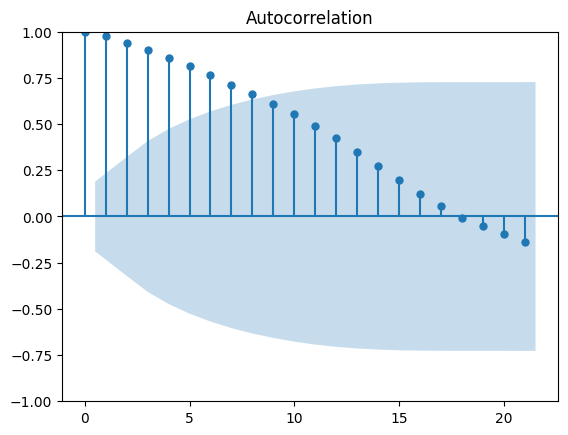

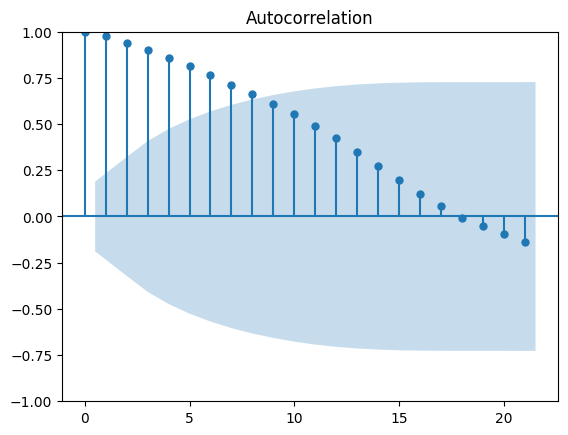

In [95]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#shows autocorrelation for time series lags
plot_acf(s)

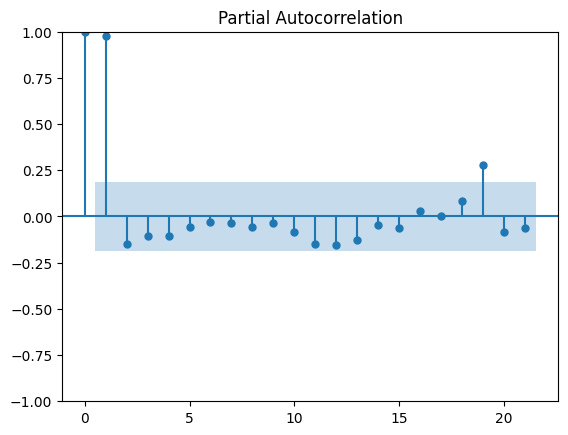

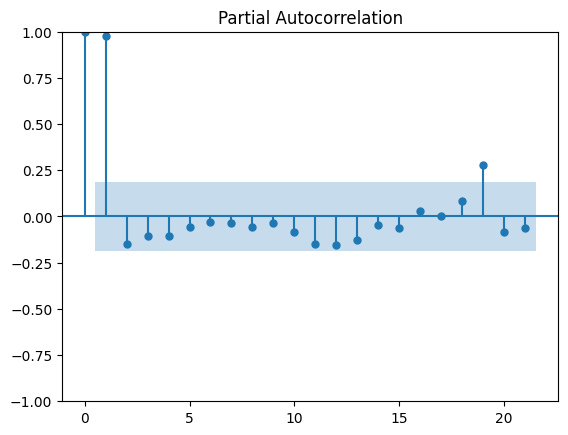

In [ ]:
plot_pacf(s)

#peaks at 1 and 19

In [35]:
# train test splits
split_idx = int(len(s) * 0.70)
# 70% of the data
train = s.iloc[:split_idx]
# 30% of the data
test  = s.iloc[split_idx:]


Baseline RMSE: 2,351.467


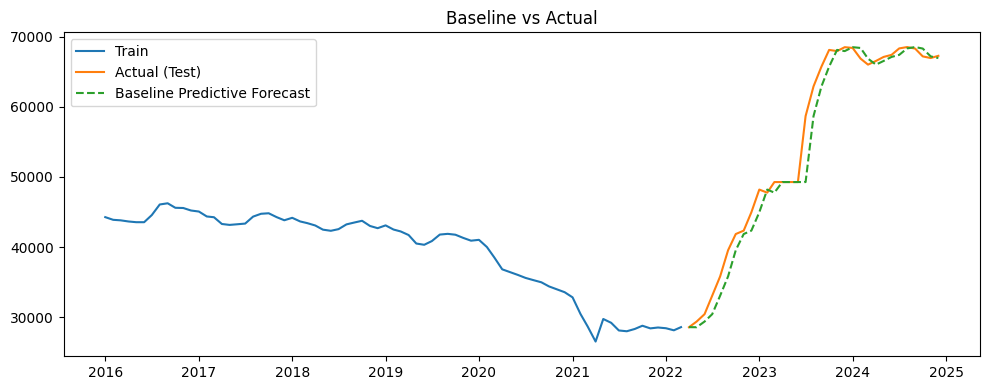

In [36]:
# baseline prediction is using the previous value as the way to predict the next value
predict = s.shift(1)[test.index]
rmse_baseline = np.sqrt(mean_squared_error(test,predict))


print(f"Baseline RMSE: {rmse_baseline:,.3f}")

plt.figure(figsize=(10,4))
plt.plot(train, label="Train")
plt.plot(test, label="Actual (Test)", color="#ff7f0e")
plt.plot(predict, label="Baseline Predictive Forecast", color="#2ca02c", linestyle="--")
plt.title('Baseline vs Actual')
plt.legend()
plt.tight_layout()
plt.show()


In [63]:
corr_test = fact_owner_demo.copy()

corr_test = corr_test[['month_date','job_typeid','ownership_id']]
corr_test = corr_test[(corr_test['ownership_id'] == 'affordable') & (corr_test['job_typeid'] == 'demolition')]

corr_test.sort_values(by='month_date',ascending=False)

corr_test['month_date'] = pd.to_datetime(corr_test['month_date'])

corr_test = corr_test.groupby('month_date').agg({'job_typeid':'count'})

# create an empty df to merge with original data and have all months (even ones with 0 demolitions)
empty = pd.date_range(start='2016-01-01',end='2024-12-01',freq='MS')
datedf = pd.DataFrame(data=empty)

datedf = datedf.rename(mapper={0:'month_date'},axis=1)
datedf = datedf.merge(corr_test,how='left',on='month_date')
datedf = datedf.fillna(0)

# complete merge of dates, counts of affordable demolitions and shelter counts
datedf = datedf.merge(shelter,how='left',on='month_date')

datedf.set_index(keys='month_date')

datedf = datedf.rename(mapper={'job_typeid':'affordable_demo'},axis=1)

datedf.set_index("month_date",inplace=True)

In [78]:
# 70% of the data
trainx = datedf['shelter_count'].iloc[:split_idx]
trainexogx = datedf['affordable_demo'].iloc[:split_idx]
# 30% of the data
testx  = datedf['shelter_count'].iloc[split_idx:]
testexogx = datedf['affordable_demo'].iloc[split_idx:]

In [112]:
# --- Fit SARIMA(p, d, q)(P, D, Q)s ---
model = SARIMAX(
    trainx,
    exog=trainexogx,
    order=(2, 0, 2),        # ARIMA part: p, d, q
    seasonal_order=(1, 1, 1, 12),   # Seasonal: P, D, Q, s (e.g., 12 months)
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit()

/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Sarima (1,1,1,12) RMSE: 9,355.926


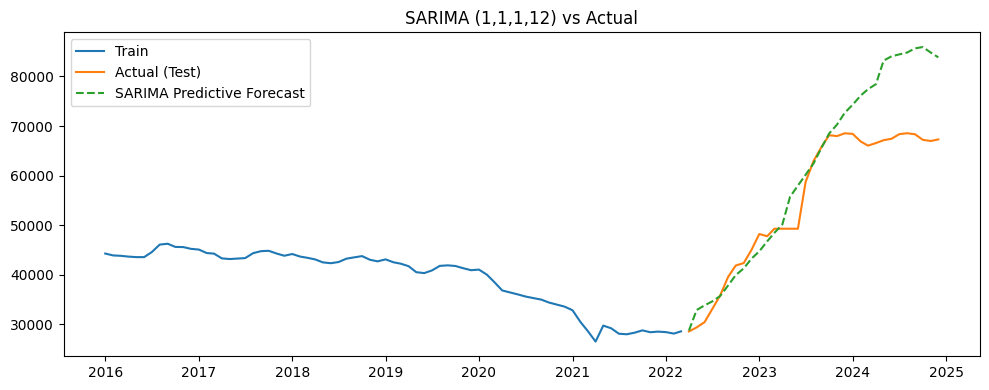

In [ ]:
predx = results.get_forecast(steps=len(testx),exog=testexogx)
predictionsx = predx.predicted_mean
sarima_rmsex = np.sqrt(mean_squared_error(testx, predictionsx))

print(f"Sarimax (1,1,1,12) RMSE: {sarima_rmsex:,.3f}")

plt.figure(figsize=(10,4))
plt.plot(trainx, label="Train")
plt.plot(testx, label="Actual (Test)", color="#ff7f0e")
plt.plot(predictionsx, label="SARIMA Predictive Forecast", color="#2ca02c", linestyle="--")
plt.title("SARIMAX (1,1,1,12) vs Actual")
plt.legend()
plt.tight_layout()
plt.show()